In [1]:
import numpy as np
import matplotlib.pyplot as plt
from inspect import signature
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
import copy
from scipy.interpolate import CubicSpline
from scipy.stats import gaussian_kde


In [2]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class MLP(nn.Module):
    def __init__(self,
                 in_dim = 1,
                 out_dim = 1,
                 widths = [64, 128, 128, 64]):
        super(MLP, self).__init__()
        
        widths = [in_dim] + list(widths) + [out_dim]
        self.n_layers = len(widths) - 1
        self.layers = nn.ModuleList([nn.Linear(widths[i], widths[i+1]) for i in range(self.n_layers)])
        #self.activation = Swish()#nn.ReLU()
        self.activation = nn.LeakyReLU(inplace=True)
    def forward(self, x):
        for i in range(self.n_layers - 1):
            x = self.layers[i](x)
            x = self.activation(x)
        x = self.layers[-1](x)
        return x

#----------------------------

def train(model, optimizer, scheduler, training_loader, val_loader, epochs = 10, loss =  nn.MSELoss(), freq_print = 1, tag = ""):

    best_model_testing_error = 1000

    for epoch in range(epochs):
        train_mse = 0.0
        for step, (input_batch, output_batch) in enumerate(training_loader):
            optimizer.zero_grad()
            output_pred_batch = model(input_batch)
            loss_f = loss(output_pred_batch, output_batch)
            loss_f.backward()
            optimizer.step()
            train_mse += loss_f.item()
        train_mse /= len(training_loader)

        scheduler.step()

        with torch.no_grad():
            model.eval()
            test_relative_l2 = 0.0
            for step, (input_batch, output_batch) in enumerate(val_loader):
                output_pred_batch = model(input_batch)
                #loss_f = (torch.mean((abs(output_pred_batch - output_batch))) / torch.mean(abs(output_batch))) * 100
                #loss_f = torch.mean(100* torch.norm(output_pred_batch - output_batch, p=2, dim = [1])/torch.norm(output_batch, p=2,dim = [1]))
                loss_f = torch.mean(torch.norm(output_pred_batch - output_batch, p=2, dim = [1]))

                test_relative_l2 += loss_f.item()
            test_relative_l2 /= len(val_loader)


        if test_relative_l2 < best_model_testing_error:
            best_model_testing_error = test_relative_l2
            best_model = copy.deepcopy(model)
            torch.save(best_model, f"saved_models/model_1d_{tag}.pkl")

        if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L1 Test Norm:", test_relative_l2)

    return best_model
    

In [3]:
def gaussian_pdf(x, mean, std_dev = 0.5):
    return (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-((x - mean) ** 2) / (2 * std_dev ** 2))

#-----

def func_linear(x):
    if x<0:
        return -x
    else:
        return x

def func_nonlinear(x):
    if x<0:
        return -0.5*x**4-x**3+x**2+0.75*x+np.sin(4*x)
    else:
        return 0.5*x**4-x**3+0.25*x**2+0.75*x+np.sin(4*x)

def func_nonlinear2(x):
    if x<0:
        return -0.25*x**4-x**3
    else:
        return -0.25*x**4+x**3

def func_sine(x):
    if x<0:
        return np.sin(4*x) - 2*np.sin(x) + x**2
    else:
        return np.sin(x) + 2*np.sin(2*x) + x**2


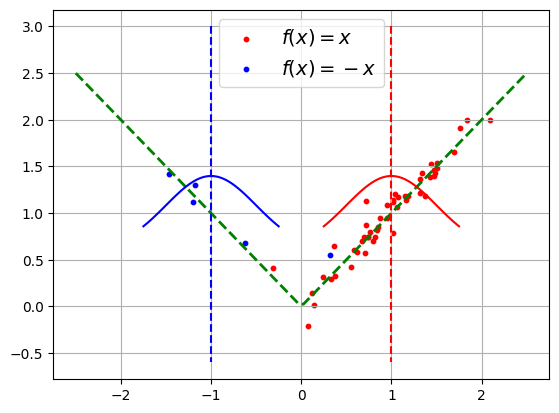

In [4]:
# Train:
F = func_linear

if F is func_sine:
    label_neg = "$f(x) = sin(4x) - 2sin(x) + x^2$"
    label_pos = "$f(x) = sin(x) + 2sin(x) + x^2$"
    file_label = "sine"
    N_train_pos = 50
    N_train_neg = 5
elif F is func_linear:
    label_neg = "$f(x) = -x$"
    label_pos = "$f(x) = x$"
    N_train_pos = 50
    N_train_neg = 5
    file_label = "linear"
elif F is func_nonlinear:
    label_neg = "$f(x) = -0.5x^4-x^3+x^2+0.75x+sin(4x)$"
    label_pos = "$f(x) =  0.5x^4-x^3+0.25x^2+0.75x+sin(4x)$"
    file_label = "ninelinear1"
    N_train_pos = 50
    N_train_neg = 5
elif F is func_nonlinear2:
    label_neg = "$f(x) = -0.25x^4-x^3$"
    label_pos = "$f(x) = -0.25x^4+x^3$"
    file_label = "ninelinear2"
    N_train_pos = 100
    N_train_neg = 10


vectorized_func = np.vectorize(F)

x_train_pos = np.random.normal(loc=1.0, scale=0.5, size=N_train_pos)
x_train_neg = np.random.normal(loc=-1.0, scale=0.5, size=N_train_neg)
noise = 0.1
y_train_pos = vectorized_func(x_train_pos) + np.random.normal(loc = 0.0, scale=noise,size=N_train_pos)
y_train_neg = vectorized_func(x_train_neg) + np.random.normal(loc=0.0, scale=noise, size=N_train_neg)

#---------------------
# Val:

N_val_pos = N_train_pos//2
N_val_neg = N_train_neg//2
x_val_pos = np.random.normal(loc=1.0, scale=0.5, size=N_val_pos)
x_val_neg = np.random.normal(loc=-1.0, scale=0.5, size=N_val_neg)
y_val_pos = vectorized_func(x_val_pos)
y_val_neg = vectorized_func(x_val_neg)

#---------------------
# Test:

N_test_pos = 512
N_test_neg = 512
x_test_pos = np.random.normal(loc=1.0, scale=0.5, size=N_test_pos)
x_test_neg = np.random.normal(loc=-1.0, scale=0.5, size=N_test_neg)
y_test_pos = vectorized_func(x_test_pos)
y_test_neg = vectorized_func(x_test_neg)

#---------------------
# PLOT:

X = np.linspace(-2.5,2.5,100)
Y = vectorized_func(X)
plt.plot(X,Y,"--", color = "green", linewidth = 2)
plt.scatter(x_train_pos, y_train_pos, s = 10, color = "red", label = label_pos)
plt.scatter(x_train_neg, y_train_neg, s = 10, color = "blue", label = label_neg)

plt.grid(True)

vectorized_func_gauss = np.vectorize(gaussian_pdf)
X = np.linspace(0.25,2-0.25, 100)
Y_pdf_pos = vectorized_func_gauss(X, 1) + F(1) - 0.4
plt.plot(X,Y_pdf_pos, color = "red")
X = np.linspace(-1.75,-0.25, 100)
Y_pdf_neg = vectorized_func_gauss(X, -1) + F(-1) - 0.4
plt.plot([-1, -1], [F(-1) + 2, F(-1)-1.6], "--", color = "blue")
plt.plot([1, 1], [F(1) + 2, F(1)-1.6], "--", color = "red")

plt.plot(X,Y_pdf_neg, color = "blue")
plt.legend(fontsize = 14)
###plt.savefig(f"Figures/1d_exp/{file_label}_function_plot.png", dpi=400)


In [5]:
batch_size = 32

inp_train = np.concatenate((x_train_pos, x_train_neg), axis = 0).reshape(-1, 1)
out_train = np.concatenate((y_train_pos, y_train_neg), axis = 0).reshape(-1, 1)
inp_train, out_train = torch.tensor(inp_train).to("cuda").type(torch.float32), torch.tensor(out_train).to("cuda").type(torch.float32)

inp_val = np.concatenate((x_val_pos, x_val_neg), axis = 0).reshape(-1, 1)
out_val = np.concatenate((y_val_pos, y_val_neg), axis = 0).reshape(-1, 1)
inp_val, out_val = torch.tensor(inp_val).to("cuda").type(torch.float32), torch.tensor(out_val).to("cuda").type(torch.float32)

dataset_train = TensorDataset(inp_train, out_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataset_val = TensorDataset(inp_val, out_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)


In [625]:
learning_rate = 0.01
weight_decay = 1e-10
step_size = 50
gamma = 0.8
epochs = 500

tag = "tmp"

model = MLP(widths = [128]).to("cuda")
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

model = train(model, optimizer, scheduler, dataloader_train, dataloader_val, epochs = epochs, freq_print=10, tag = tag)


######### Epoch: 0  ######### Train Loss: 0.2859320193529129  ######### Relative L1 Test Norm: 0.5051354765892029
######### Epoch: 10  ######### Train Loss: 0.03275572322309017  ######### Relative L1 Test Norm: 0.08253418654203415
######### Epoch: 20  ######### Train Loss: 0.012717131059616804  ######### Relative L1 Test Norm: 0.07299808412790298
######### Epoch: 30  ######### Train Loss: 0.012630349025130272  ######### Relative L1 Test Norm: 0.03247005119919777
######### Epoch: 40  ######### Train Loss: 0.011579124722629786  ######### Relative L1 Test Norm: 0.03218558058142662
######### Epoch: 50  ######### Train Loss: 0.010796038433909416  ######### Relative L1 Test Norm: 0.030743654817342758
######### Epoch: 60  ######### Train Loss: 0.009683917975053191  ######### Relative L1 Test Norm: 0.027582284063100815
######### Epoch: 70  ######### Train Loss: 0.010445724707096815  ######### Relative L1 Test Norm: 0.030460240319371223
######### Epoch: 80  ######### Train Loss: 0.0094256193842

MEDIAN POS REL 0.014554738998413086 MEAN POS REL 0.015282695181667805
MEDIAN NEG REL 0.07615208625793457 MEAN NEG REL 0.0746309757232666
 
MEDIAN POS  0.014554738998413086 MEAN POS  0.015282695181667805
MEDIAN NEG  0.07615208625793457 MEAN NEG  0.0746309757232666


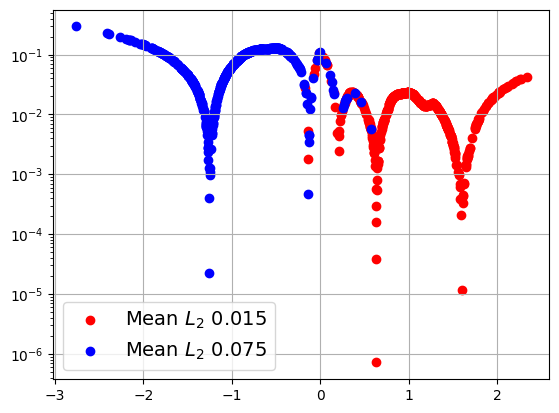

In [626]:
#inp_test_pos = np.concatenate((x_test_pos, x_test_neg), axis = 0).reshape(-1, 1)
#out_test_pos = np.concatenate((y_test_pos, y_test_neg), axis = 0).reshape(-1, 1)
inp_test_pos, out_test_pos = torch.tensor(x_test_pos).to("cuda").type(torch.float32).reshape(-1, 1), torch.tensor(y_test_pos).to("cuda").type(torch.float32).reshape(-1, 1)
inp_test_neg, out_test_neg = torch.tensor(x_test_neg).to("cuda").type(torch.float32).reshape(-1, 1), torch.tensor(y_test_neg).to("cuda").type(torch.float32).reshape(-1, 1)

pred_test_pos = model(inp_test_pos)
pred_test_neg = model(inp_test_neg)

err_pos = torch.norm(out_test_pos - pred_test_pos, p = 2, dim = [1])#/torch.norm(out_test_pos, p = 2, dim = [1])
err_neg = torch.norm(out_test_neg - pred_test_neg, p = 2, dim = [1])#/torch.norm(out_test_pos, p = 2, dim = [1])
mean_pos = round(torch.mean(err_pos).item(),3)
mean_neg = round(torch.mean(err_neg).item(),3)

#err_pos = out_test_pos - pred_test_pos
#err_neg = out_test_neg - pred_test_neg
plt.scatter(inp_test_pos[:,0].detach().cpu().numpy(), err_pos.detach().cpu().numpy(), label = f"Mean $L_2$ {mean_pos}", color = "red")
plt.scatter(inp_test_neg[:,0].detach().cpu().numpy(), err_neg.detach().cpu().numpy(),label = f"Mean $L_2$ {mean_neg}", color = "blue")

plt.yscale("log")
#plt.ylim([0,2])
plt.grid(True)
plt.legend(fontsize = 14)
###plt.savefig(f"Figures/1d_exp/{file_label}_error_plot.png", dpi=400)

print("MEDIAN POS REL", torch.median(err_pos).item(), "MEAN POS REL", torch.mean(err_pos).item())
print("MEDIAN NEG REL", torch.median(err_neg).item(), "MEAN NEG REL", torch.mean(err_neg).item())

print(" ")

err_pos  = torch.norm(out_test_pos - pred_test_pos, p = 2, dim = [1])
err_neg  = torch.norm(out_test_neg - pred_test_neg, p = 2, dim = [1])
print("MEDIAN POS ", torch.median(err_pos).item(), "MEAN POS ", torch.mean(err_pos).item())
print("MEDIAN NEG ", torch.median(err_neg).item(), "MEAN NEG ", torch.mean(err_neg).item())



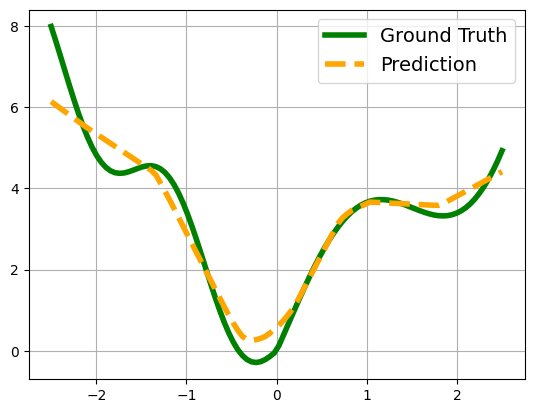

In [618]:
X = np.linspace(-2.5,2.5,100)
Y = vectorized_func(X)
plt.plot(X,Y, color = "green", label = "Ground Truth", linewidth = 4)
#plt.scatter(inp_test_pos[:,0].detach().cpu().numpy(), pred_test_pos[:,0].detach().cpu().numpy())
#plt.scatter(inp_test_neg[:,0].detach().cpu().numpy(), pred_test_neg[:,0].detach().cpu().numpy())

X = np.linspace(-2.5,2.5,100)
X = torch.tensor(X).to("cuda").type(torch.float32).reshape(-1, 1)
Y_pred = model(X)[:,0]
plt.plot(X[:,0].detach().cpu().numpy(),Y_pred.detach().cpu().numpy(),"--", color = "orange", label = "Prediction",linewidth = 4)


plt.legend(fontsize = 14)
plt.grid(True)
####plt.savefig(f"Figures/1d_exp/{file_label}_prediction_plot.png", dpi=400)


In [73]:
E_pos = []
E_neg = []
#N_train = [40, 90, 150, 300, 600, 1000]
N_train = [20, 40,80, 160, 320]
num_runs = 10

F = func_sine
vectorized_func = np.vectorize(F)

N_test_pos = 512
N_test_neg = 512
x_test_pos = np.random.normal(loc=1.0, scale=0.5, size=N_test_pos)
x_test_neg = np.random.normal(loc=-1.0, scale=0.5, size=N_test_neg)
y_test_pos = vectorized_func(x_test_pos)
y_test_neg = vectorized_func(x_test_neg)


for N_train_pos in N_train:
    E_tmp_pos = []
    E_tmp_neg = []
    for _ in range(num_runs):
        N_train_neg = N_train_pos//10
        x_train_pos = np.random.normal(loc=1.0, scale=0.5, size=N_train_pos)
        x_train_neg = np.random.normal(loc=-1.0, scale=0.5, size=N_train_neg)
        noise = 0.1
        y_train_pos = vectorized_func(x_train_pos) + np.random.normal(loc = 0.0, scale=noise,size=N_train_pos)
        y_train_neg = vectorized_func(x_train_neg) + np.random.normal(loc=0.0, scale=noise, size=N_train_neg)

        #---------------------
        # Val:

        N_val_pos = N_train_pos//2
        N_val_neg = N_train_neg//2
        x_val_pos = np.random.normal(loc=1.0, scale=0.5, size=N_val_pos)
        x_val_neg = np.random.normal(loc=-1.0, scale=0.5, size=N_val_neg)
        y_val_pos = vectorized_func(x_val_pos)
        y_val_neg = vectorized_func(x_val_neg)

        batch_size = 32

        inp_train = np.concatenate((x_train_pos, x_train_neg), axis = 0).reshape(-1, 1)
        out_train = np.concatenate((y_train_pos, y_train_neg), axis = 0).reshape(-1, 1)
        inp_train, out_train = torch.tensor(inp_train).to("cuda").type(torch.float32), torch.tensor(out_train).to("cuda").type(torch.float32)

        inp_val = np.concatenate((x_val_pos, x_val_neg), axis = 0).reshape(-1, 1)
        out_val = np.concatenate((y_val_pos, y_val_neg), axis = 0).reshape(-1, 1)
        inp_val, out_val = torch.tensor(inp_val).to("cuda").type(torch.float32), torch.tensor(out_val).to("cuda").type(torch.float32)

        dataset_train = TensorDataset(inp_train, out_train)
        dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
        dataset_val = TensorDataset(inp_val, out_val)
        dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

        learning_rate = 0.005
        weight_decay = 1e-6
        step_size = 50
        gamma = 0.8
        epochs = 500

        tag = "tmp"

        model = MLP(widths = [64, 64]).to("cuda")
        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

        model = train(model, optimizer, scheduler, dataloader_train, dataloader_val, epochs = epochs, freq_print=501, tag = tag)


        inp_test_pos, out_test_pos = torch.tensor(x_test_pos).to("cuda").type(torch.float32).reshape(-1, 1), torch.tensor(y_test_pos).to("cuda").type(torch.float32).reshape(-1, 1)
        inp_test_neg, out_test_neg = torch.tensor(x_test_neg).to("cuda").type(torch.float32).reshape(-1, 1), torch.tensor(y_test_neg).to("cuda").type(torch.float32).reshape(-1, 1)

        pred_test_pos = model(inp_test_pos)
        pred_test_neg = model(inp_test_neg)
        err_pos = torch.norm(out_test_pos - pred_test_pos, p = 2, dim = [1])#/torch.norm(out_test_pos, p = 2, dim = [1])
        err_neg = torch.norm(out_test_neg - pred_test_neg, p = 2, dim = [1])#/torch.norm(out_test_pos, p = 2, dim = [1])
        mean_pos = round(torch.mean(err_pos).item(),10)
        mean_neg = round(torch.mean(err_neg).item(),10)
        E_tmp_pos.append(mean_pos)
        E_tmp_neg.append(mean_neg)

    E_pos.append(np.median(np.array(E_tmp_pos)))
    E_neg.append(np.median(np.array(E_tmp_neg)))
    print(N_train_pos, mean_pos, mean_neg,E_pos,E_neg)
    print(" ")



######### Epoch: 0  ######### Train Loss: 10.080018997192383  ######### Relative L1 Test Norm: 3.387083053588867
######### Epoch: 0  ######### Train Loss: 11.783330917358398  ######### Relative L1 Test Norm: 2.8959362506866455
######### Epoch: 0  ######### Train Loss: 9.630470275878906  ######### Relative L1 Test Norm: 2.866251230239868
######### Epoch: 0  ######### Train Loss: 10.676615715026855  ######### Relative L1 Test Norm: 2.80753493309021
######### Epoch: 0  ######### Train Loss: 12.503750801086426  ######### Relative L1 Test Norm: 3.0135910511016846
######### Epoch: 0  ######### Train Loss: 10.429573059082031  ######### Relative L1 Test Norm: 2.9948482513427734
######### Epoch: 0  ######### Train Loss: 12.816717147827148  ######### Relative L1 Test Norm: 3.255802631378174
######### Epoch: 0  ######### Train Loss: 12.363408088684082  ######### Relative L1 Test Norm: 2.5601913928985596
######### Epoch: 0  ######### Train Loss: 10.08592414855957  ######### Relative L1 Test Norm: 

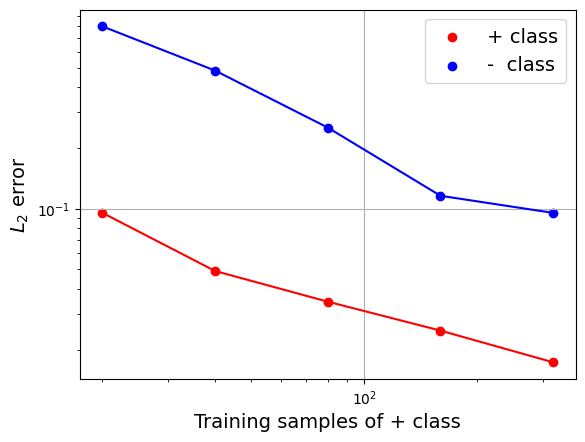

In [74]:
#nonlinear1
#N_train = [20, 40,80, 160, 320, 500]
#E_pos = [0.07917059955, 0.0458901096, 0.03587754815, 0.0276526073, 0.02337893655, 0.01940843745]
#E_neg =  [0.9047985971, 0.4922428429, 0.13498322670000001, 0.08447036150000001, 0.05450362525, 0.04667258075]

#nonlinear2
#N_train = [20, 40,80, 160, 320]
#E_pos, E_neg = [0.0462670997, 0.03280890545, 0.02088025955, 0.01466236495, 0.010785177850000001], [0.1635358632, 0.1206093505, 0.07737971095, 0.04410991255, 0.02488801815]

#linear
#N_train = [20, 30, 40, 50, 60]
#[0.0358799379, 0.0226040911, 0.02081691845, 0.0176277291, 0.01776444635] [0.1191874184, 0.08351454885000001, 0.048314053600000004, 0.04253362305, 0.04443947785]

#sine
#N_train = [20, 40,80, 160, 320]
#[0.0953678563, 0.049096530299999996, 0.0345939733, 0.0248689838, 0.01731958705] [0.80003780125, 0.48294493555, 0.25206615775, 0.1157789081, 0.09522732719999999]


plt.scatter(N_train, E_pos, color = "red", label = "+ class")
plt.plot(N_train, E_pos, color = "red")

plt.scatter(N_train, E_neg, color = "blue",label = "-  class")
plt.plot(N_train, E_neg,color = "blue")

plt.grid(True)
plt.yscale("log")
plt.xscale("log")

plt.xlabel("Training samples of + class", fontsize = 14)
plt.ylabel("$L_2$ error", fontsize = 14)
plt.legend(fontsize = 14)

file_label = "10percent_SCALE_func_sine"
plt.savefig(f"Figures/1d_exp/{file_label}.png", dpi=400)


plt.show()




In [63]:
E_pos = []
E_neg = []
Portion = [0.05, 0.10, 0.25, 0.5, 1.0]
num_runs = 20
F = func_nonlinear2

vectorized_func = np.vectorize(F)
N_train_pos = 200

N_test_pos = 512
N_test_neg = 512
x_test_pos = np.random.normal(loc=1.0, scale=0.5, size=N_test_pos)
x_test_neg = np.random.normal(loc=-1.0, scale=0.5, size=N_test_neg)
y_test_pos = vectorized_func(x_test_pos)
y_test_neg = vectorized_func(x_test_neg)


for portion in Portion:
    err_pos = torch.zeros(0,)
    err_neg = torch.zeros(0,)
    E_tmp_pos = []
    E_tmp_neg = []
    for _ in range(num_runs):
        N_train_neg = int(N_train_pos*portion)
        x_train_pos = np.random.normal(loc=1.0, scale=0.5, size=N_train_pos)
        x_train_neg = np.random.normal(loc=-1.0, scale=0.5, size=N_train_neg)
        noise = 0.1
        y_train_pos = vectorized_func(x_train_pos) + np.random.normal(loc = 0.0, scale=noise,size=N_train_pos)
        y_train_neg = vectorized_func(x_train_neg) + np.random.normal(loc=0.0, scale=noise, size=N_train_neg)

        #---------------------
        # Val:

        N_val_pos = N_train_pos//2
        N_val_neg = N_train_neg//2
        x_val_pos = np.random.normal(loc=1.0, scale=0.5, size=N_val_pos)
        x_val_neg = np.random.normal(loc=-1.0, scale=0.5, size=N_val_neg)
        y_val_pos = vectorized_func(x_val_pos)
        y_val_neg = vectorized_func(x_val_neg)

        batch_size = 32

        inp_train = np.concatenate((x_train_pos, x_train_neg), axis = 0).reshape(-1, 1)
        out_train = np.concatenate((y_train_pos, y_train_neg), axis = 0).reshape(-1, 1)
        inp_train, out_train = torch.tensor(inp_train).to("cuda").type(torch.float32), torch.tensor(out_train).to("cuda").type(torch.float32)

        inp_val = np.concatenate((x_val_pos, x_val_neg), axis = 0).reshape(-1, 1)
        out_val = np.concatenate((y_val_pos, y_val_neg), axis = 0).reshape(-1, 1)
        inp_val, out_val = torch.tensor(inp_val).to("cuda").type(torch.float32), torch.tensor(out_val).to("cuda").type(torch.float32)

        dataset_train = TensorDataset(inp_train, out_train)
        dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
        dataset_val = TensorDataset(inp_val, out_val)
        dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

        learning_rate = 0.005
        weight_decay = 0
        step_size = 50
        gamma = 0.8
        epochs = 500

        tag = "tmp"

        model = MLP(widths = [64, 64]).to("cuda")
        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

        model = train(model, optimizer, scheduler, dataloader_train, dataloader_val, epochs = epochs, freq_print=499, tag = tag)


        inp_test_pos, out_test_pos = torch.tensor(x_test_pos).to("cuda").type(torch.float32).reshape(-1, 1), torch.tensor(y_test_pos).to("cuda").type(torch.float32).reshape(-1, 1)
        inp_test_neg, out_test_neg = torch.tensor(x_test_neg).to("cuda").type(torch.float32).reshape(-1, 1), torch.tensor(y_test_neg).to("cuda").type(torch.float32).reshape(-1, 1)

        pred_test_pos = model(inp_test_pos)
        pred_test_neg = model(inp_test_neg)
        err_pos = torch.norm(out_test_pos - pred_test_pos, p = 2, dim = [1])#/torch.norm(out_test_pos, p = 2, dim = [1])
        err_neg = torch.norm(out_test_neg - pred_test_neg, p = 2, dim = [1])#/torch.norm(out_test_pos, p = 2, dim = [1])
        mean_pos = round(torch.mean(err_pos).item(),10)
        mean_neg = round(torch.mean(err_neg).item(),10)
        E_tmp_pos.append(mean_pos)
        E_tmp_neg.append(mean_neg)

    E_pos.append(np.median(np.array(E_tmp_pos)))
    E_neg.append(np.median(np.array(E_tmp_neg)))
    print(N_train_pos, mean_pos, mean_neg,E_pos,E_neg)
    print(" ")


######### Epoch: 0  ######### Train Loss: 0.955575806753976  ######### Relative L1 Test Norm: 0.725677028298378
######### Epoch: 499  ######### Train Loss: 0.008282775525003672  ######### Relative L1 Test Norm: 0.019855164224281907
######### Epoch: 0  ######### Train Loss: 1.1501333202634538  ######### Relative L1 Test Norm: 0.9280887842178345
######### Epoch: 499  ######### Train Loss: 0.008119901642203331  ######### Relative L1 Test Norm: 0.01898770988918841
######### Epoch: 0  ######### Train Loss: 1.364610995565142  ######### Relative L1 Test Norm: 0.858655110001564
######### Epoch: 499  ######### Train Loss: 0.009689446272594588  ######### Relative L1 Test Norm: 0.01890328386798501
######### Epoch: 0  ######### Train Loss: 1.4181515319006783  ######### Relative L1 Test Norm: 0.5741769373416901
######### Epoch: 499  ######### Train Loss: 0.009075197191642863  ######### Relative L1 Test Norm: 0.03552373684942722
######### Epoch: 0  ######### Train Loss: 1.273962846824101  ######### 

[0.0145418085, 0.01482689195, 0.01441303965, 0.01636228245, 0.01390724115] [0.0626290422, 0.035439837749999994, 0.0235342989, 0.017811215499999998, 0.0154523663]
-8.448806420550202 -0.7350378192908668


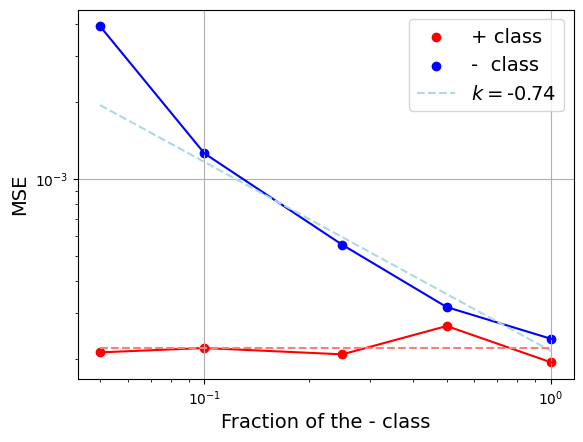

In [65]:
#sine:
#Portion = [0.05, 0.10, 0.25, 0.5, 1.0]
#E_pos, E_neg = [0.024862793299999998, 0.0262200432, 0.02464668735, 0.023585286, 0.021718901550000003], [0.16399405150000002, 0.0972213857, 0.076026015,0.06520859155, 0.03981854395]

#linear:
#Portion = [0.05, 0.10, 0.25, 0.5, 1.0]
#E_pos, E_neg = [0.01141831465, 0.01230883925, 0.01069385185, 0.014371905, 0.0121010314], [0.0482868347, 0.03359374405, 0.0186007703, 0.01667006405, 0.010735863799999999]

#nonlinear
'''
E_pos, E_neg = [0.00052396, 0.0005703,  0.0005608,  0.0004537,  0.00052371], [0.00905164, 0.00475779, 0.00161824, 0.00097238, 0.00069069]
E_neg = np.array(E_neg)
E_pos = np.array(E_pos)
'''
#nonlinear2
#[0.0145418085, 0.01482689195, 0.01441303965, 0.01636228245, 0.01390724115] [0.0626290422, 0.035439837749999994, 0.0235342989, 0.017811215499999998, 0.0154523663]


print(E_pos, E_neg)
Portion = np.array(Portion)
E_neg = np.array(E_neg)**2
E_pos = np.array(E_pos)**2

plt.scatter(Portion, E_pos, color = "red", label = "+ class")
plt.plot(Portion, E_pos, color = "red")

plt.scatter(Portion, E_neg, color = "blue",label = "-  class")
plt.plot(Portion, E_neg,color = "blue")


z = np.polyfit(np.log(Portion[1:]), np.log(E_neg[1:]), 1)
X = np.log(np.linspace(0.05, 1.0, 100))
Y = z[1] + z[0]*X
plt.plot(np.exp(X),np.exp(Y), "--", color = "lightblue", label = "$k=$"+str(round(z[0],2)))
print(z[1], z[0])

plt.plot(np.exp(X), np.ones_like(X)*np.mean(E_pos),"--", color = "salmon")

plt.grid(True)
plt.yscale("log")
plt.xscale("log")

plt.xlabel("Fraction of the - class", fontsize = 14)
plt.ylabel("MSE", fontsize = 14)
plt.legend(fontsize = 14)


file_label = f"Portion_SCALE_fit_{F.__name__}_{N_train_pos}"
plt.savefig(f"Figures/1d_exp/{file_label}.png", dpi=400)


plt.show()




In [3]:
plt.scatter(Portion, np.array(E_neg)/np.array(E_pos), color = "green", s= 50)

plt.xlabel("Fraction of the - class", fontsize = 14)
plt.ylabel("E$_{+}/$"+"E$_{-}$", fontsize = 14)
plt.grid(True)
plt.yscale("log")
plt.xscale("log")

NameError: name 'Portion' is not defined

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


In [46]:
def f_sine(x):
    return np.where(x < 0, np.sin(2*np.pi*x), np.sin(30*np.pi * x))

def get_dataset(N, batch_size=64):
    X = np.random.uniform(-1,1,N)
    Y = f_sine(X).reshape(-1,1)
    X = X.reshape(-1,1)
    return torch.tensor(X).to("cuda").type(torch.float32), torch.tensor(Y).to("cuda").type(torch.float32)


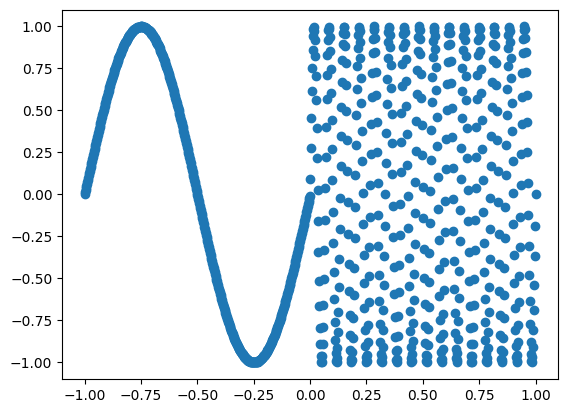

In [47]:
X = np.linspace(-1,1,1000)
plt.scatter(X, f_sine(X))

In [48]:
batch_size = 64
N_train = 1024
N_val = 256
N_test = 1024


inp_train, out_train = get_dataset(N_train, batch_size=batch_size)
inp_val, out_val = get_dataset(N_val, batch_size=batch_size)
inp_test, out_test = get_dataset(N_test, batch_size=batch_size)

#-------------

dataset_train = TensorDataset(inp_train, out_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataset_val = TensorDataset(inp_val, out_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

learning_rate = 0.005
weight_decay = 0
step_size = 50
gamma = 0.8
epochs = 500

tag = "tmp"

model = MLP(widths = [64, 64]).to("cuda")
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

model = train(model, optimizer, scheduler, dataloader_train, dataloader_val, epochs = epochs, freq_print=50, tag = tag)



######### Epoch: 0  ######### Train Loss: 0.45964418165385723  ######### Relative L1 Test Norm: 0.5577043145895004
######### Epoch: 50  ######### Train Loss: 0.23580811824649572  ######### Relative L1 Test Norm: 0.3283194974064827
######### Epoch: 100  ######### Train Loss: 0.2359546422958374  ######### Relative L1 Test Norm: 0.32848741859197617
######### Epoch: 150  ######### Train Loss: 0.23446413315832615  ######### Relative L1 Test Norm: 0.32095376402139664
######### Epoch: 200  ######### Train Loss: 0.2323062475770712  ######### Relative L1 Test Norm: 0.3209212124347687
######### Epoch: 250  ######### Train Loss: 0.23079505283385515  ######### Relative L1 Test Norm: 0.3257589116692543
######### Epoch: 300  ######### Train Loss: 0.23017205856740475  ######### Relative L1 Test Norm: 0.3246035873889923
######### Epoch: 350  ######### Train Loss: 0.22699821647256613  ######### Relative L1 Test Norm: 0.31872352957725525
######### Epoch: 400  ######### Train Loss: 0.22574015147984028  #

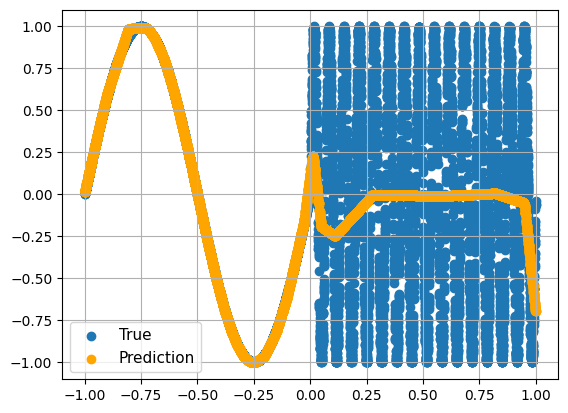

In [54]:

inp_test, out_test = get_dataset(10000)
plt.scatter(inp_test[:,0].detach().cpu().numpy(), f_sine(inp_test[:,0].detach().cpu().numpy()),label = "True")

Y_pred = model(inp_test)[:,0]
plt.scatter(inp_test[:,0].detach().cpu().numpy(), Y_pred.detach().cpu().numpy(), color = "orange", label = "Prediction")

plt.legend(fontsize = 11)
plt.grid(True)

In [ ]:
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    avg_loss_val = 0.

    score_model.train()
    lr = get_lr_cosine_linear_warmup(epoch, warmup_epochs, n_epochs, peak_lr, end_lr)
    for param_group in optimizer.param_groups:
          param_group['lr'] = lr  # Update optimizer LR

    for input_batch, output_batch in train_loader:
      input_batch = input_batch.to(device)
      output_batch = output_batch.to(device)

      if which_type == "xy":
        loss = loss_fn(score_model, input_batch, output_batch, marginal_prob_std_fn)
        condition = output_batch
      elif which_type == "yx":
        loss = loss_fn(score_model, output_batch, input_batch, marginal_prob_std_fn)
        condition = input_batch
      elif which_type == "x":
        loss = loss_fn(score_model, input_batch, None, marginal_prob_std_fn)
        condition = None
      elif which_type == "y":
        loss = loss_fn(score_model, output_batch, None, marginal_prob_std_fn)
        condition = None
      elif which_type == "x&y":
        loss = loss_fn(score_model, torch.cat((input_batch, output_batch), axis = 1), None, marginal_prob_std_fn)
        condition = None
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      ema.update()

      avg_loss += loss.item() * output_batch.shape[0]
      num_items += output_batch.shape[0]
    avg_loss /= num_items

    score_model.eval()
    num_items = 0
    with torch.no_grad():
        for input_batch, output_batch in val_loader:
          #x = torch.cat((input_batch, output_batch), dim = 1)
          input_batch = input_batch.to(device)
          output_batch = output_batch.to(device)

          loss = loss_fn(score_model, variable, condition, marginal_prob_std_fn)
          avg_loss_val += loss.item() * output_batch.shape[0]
          num_items += output_batch.shape[0]
    avg_loss_val/= num_items
    